In [1]:
import os
import copy

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [3]:
# Load HGDP
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/HGDP_sub/'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet.hdf5'
metadata_file = 'labels.tsv'
unrelated_sampleid_1000G_path = '/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/1000G_unrelated_samples_set_2504.txt'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs, class_labels, sample, snp_names, class_label_names, metadata_labels = data_loader.load_data_HDGP(data_path, metadata_path, unrelated_sampleid_1000G_path)

Removed 701 related individuals


In [4]:
#np.save('inputs_hgdp', inputs)
#metadata_labels.to_csv('metadata_labels_hgdp')
#pd.DataFrame(sample).to_csv('samples')

In [5]:
def make_palette_label_order_HGDP(metadata_labels):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

In [6]:
pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(metadata_labels)

## Make PCA

In [7]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

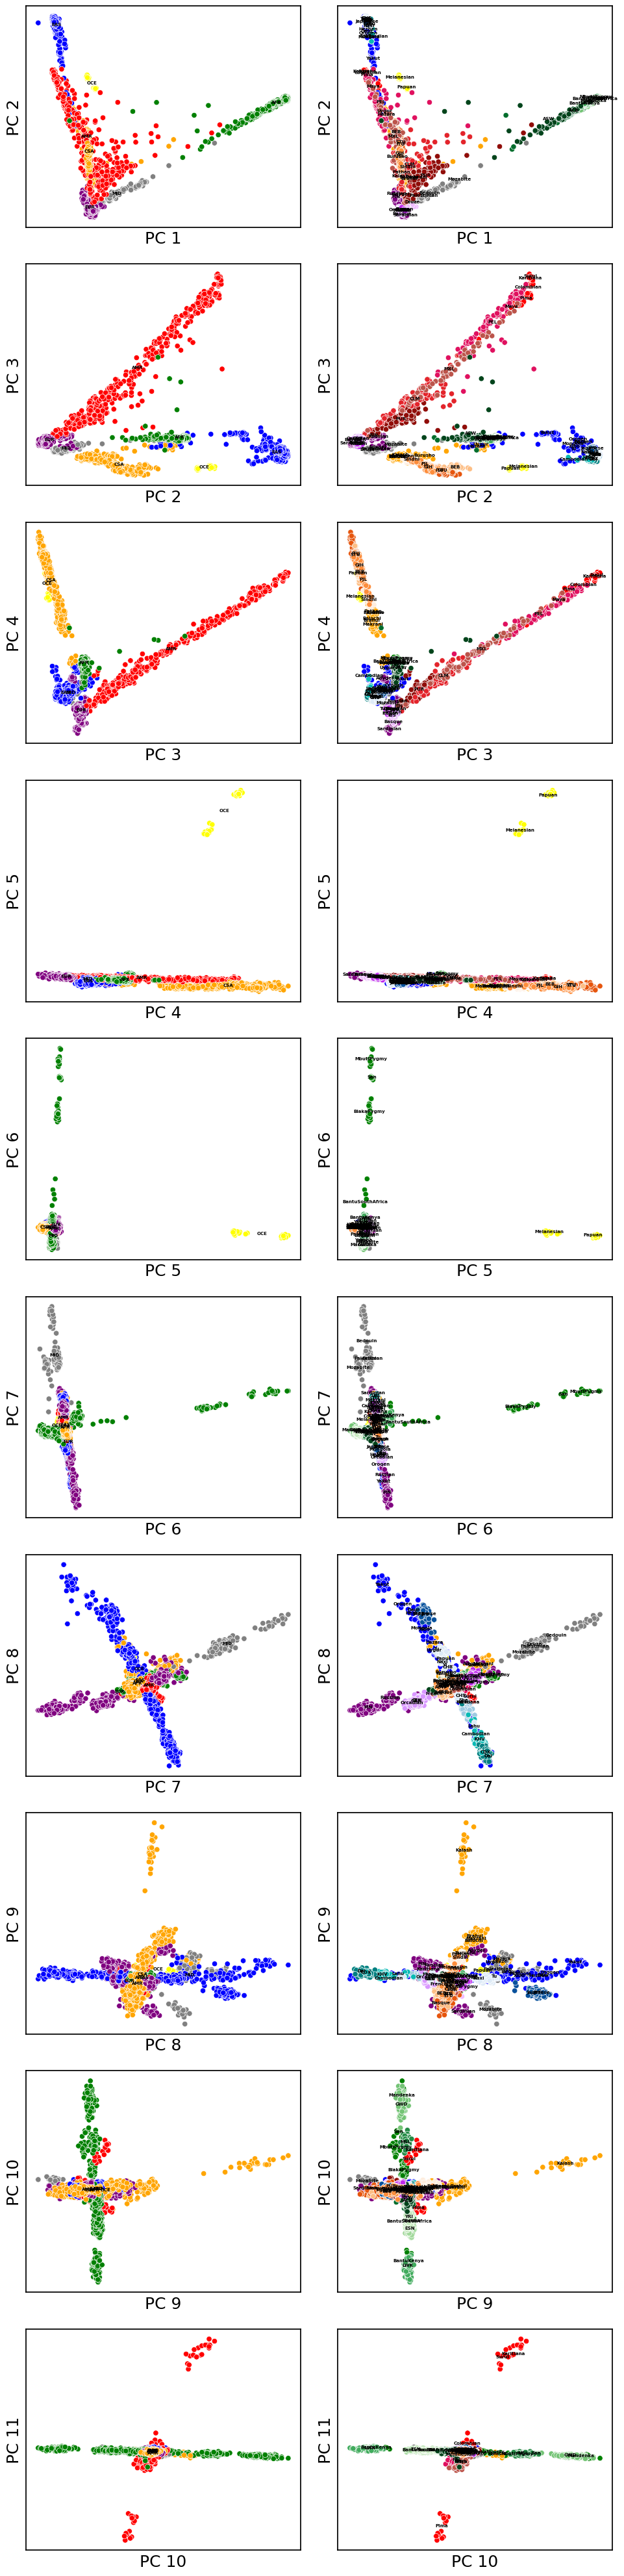

In [8]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,40))
for comp in range(10):
# initial 2D phate embedding
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Superpopulation'].values, 
                             None,
                             pop_palette_hgdp_coarse,
                             label_order_hgdp_coarse,
                             True,
                             ax[comp, 0])
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Population'].values, 
                             None,
                             pop_palette_hgdp_fine,
                             label_order_hgdp_fine,
                             True,
                             ax[comp, 1])
    #ax[comp, 0].get_legend().remove()
    #ax[comp, 1].get_legend().remove()
    ax[comp, 0].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 0].set_ylabel('PC {}'.format(comp+2))
    ax[comp, 1].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 1].set_ylabel('PC {}'.format(comp+2))
plt.tight_layout()
fig.savefig('figures/PCA_1000G+HGDP')

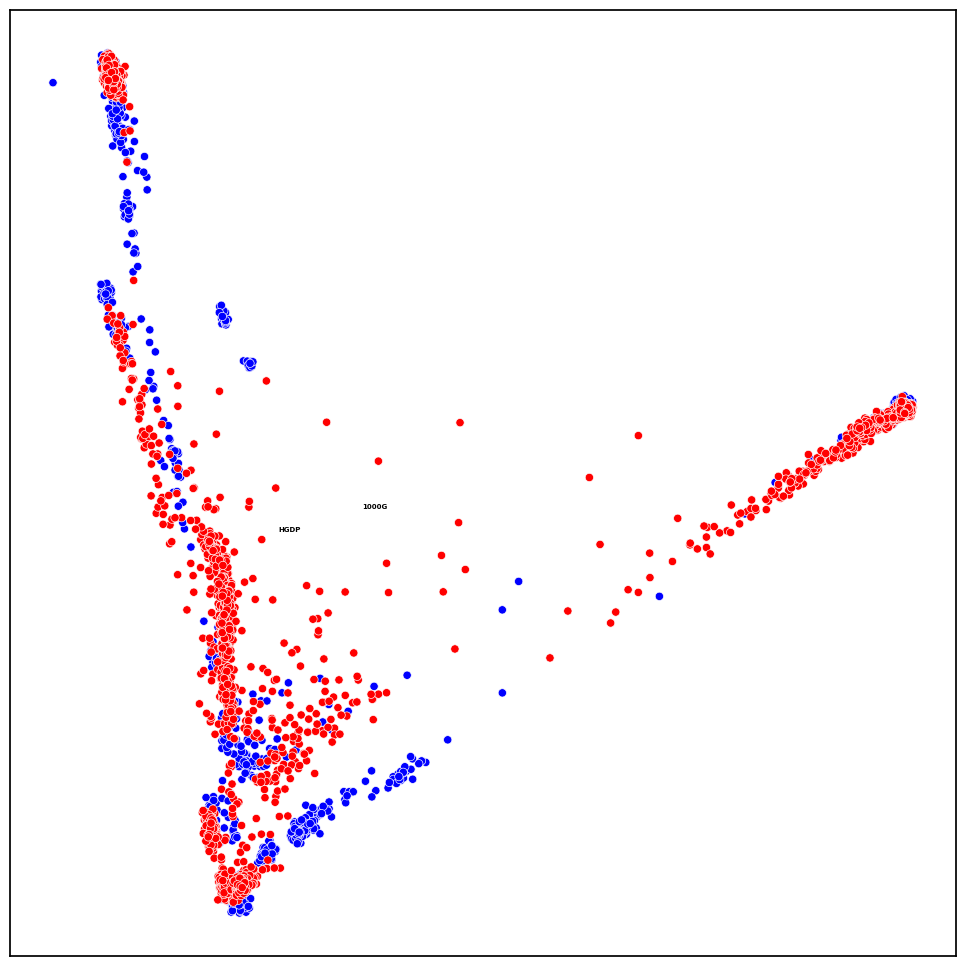

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

plotting.plot_embeddings(pca_input, 
                         metadata_labels['db'].values, 
                         None,
                         {'1000G': 'red', 'HGDP': 'blue'},
                         ['1000G', 'HGDP'],
                         True,
                         ax)
plt.tight_layout()

In [10]:
# get PCA loadings
loadings = pca_obj.components_.T * np.sqrt(pca_obj.explained_variance_)
loadings_df = pd.DataFrame(loadings).set_index(snp_names)
loadings_df.to_csv('1000G+HGDP_loadings')

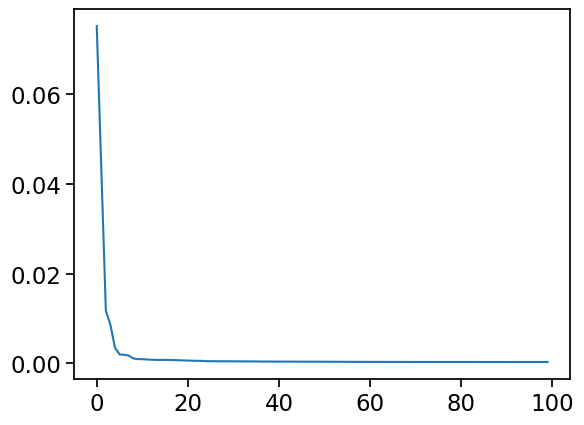

In [11]:
plt.plot(pca_obj.explained_variance_ratio_)

## Remove Admixed Populations

In [12]:
to_exclude = ['PEL', 'PUR', 'CLM', 'Colombian', 'MXL']
idx_to_keep = (~metadata_labels['Population'].isin(to_exclude)).values

In [13]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs[idx_to_keep])

In [14]:
pop_palette_hgdp_fine_noadmixAMR = copy.deepcopy(pop_palette_hgdp_fine)
for x in to_exclude:
    _ = pop_palette_hgdp_fine_noadmixAMR.pop(x)

In [15]:
label_order_hgdp_fine_noadmixAMR = copy.deepcopy(label_order_hgdp_fine)
for x in to_exclude:
    label_order_hgdp_fine_noadmixAMR.remove(x)

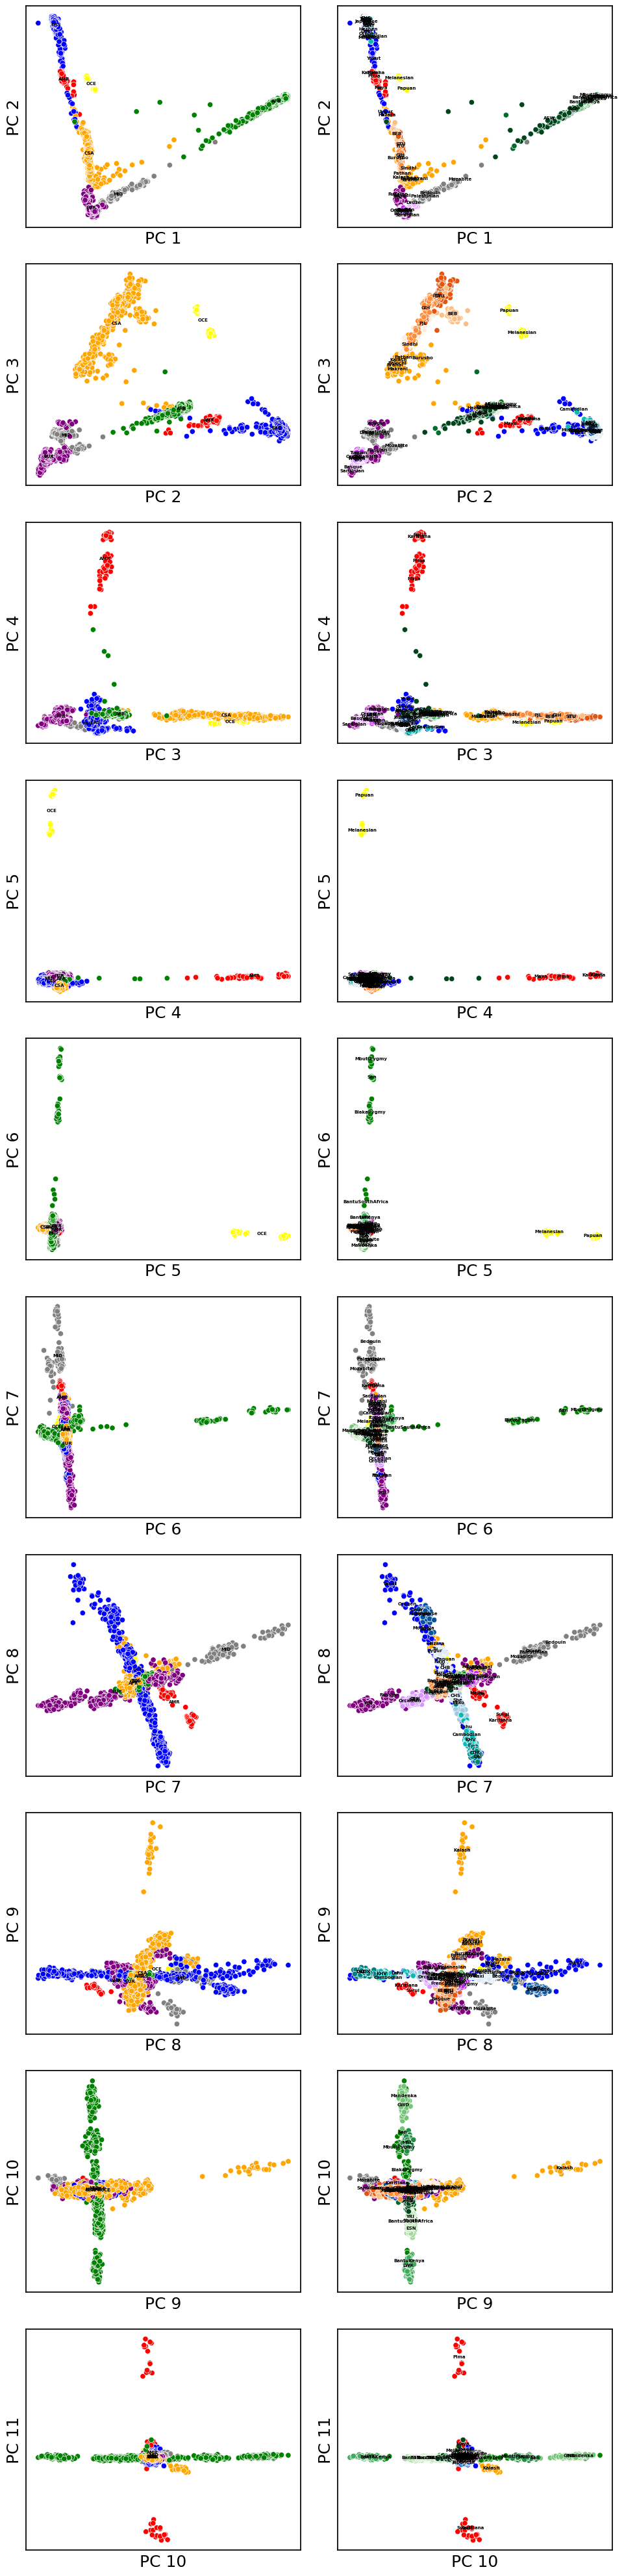

In [16]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,40))
for comp in range(10):
# initial 2D phate embedding
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Superpopulation'].values[idx_to_keep], 
                             None,
                             pop_palette_hgdp_coarse,
                             label_order_hgdp_coarse,
                             True,
                             ax[comp, 0])
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Population'].values[idx_to_keep], 
                             None,
                             pop_palette_hgdp_fine_noadmixAMR,
                             label_order_hgdp_fine_noadmixAMR,
                             True,
                             ax[comp, 1])
    ax[comp, 0].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 0].set_ylabel('PC {}'.format(comp+2))
    ax[comp, 1].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 1].set_ylabel('PC {}'.format(comp+2))
plt.tight_layout()
fig.savefig('figures/PCA_1000G+HGDP_noadmixAMR')

## Balance Populations

In [17]:
idx_to_keep = []
for pop in metadata_labels['Population'].unique():
    pop_sample_id = metadata_labels[metadata_labels['Population'] == pop].index
    if len(pop_sample_id) < 20:
        idx_to_keep += pop_sample_id.tolist()
    else:
        r_ids = np.random.choice(pop_sample_id, 20, replace=False)
        idx_to_keep += r_ids.tolist()
idx_to_keep = (metadata_labels.index.isin(idx_to_keep))

In [18]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs[idx_to_keep])

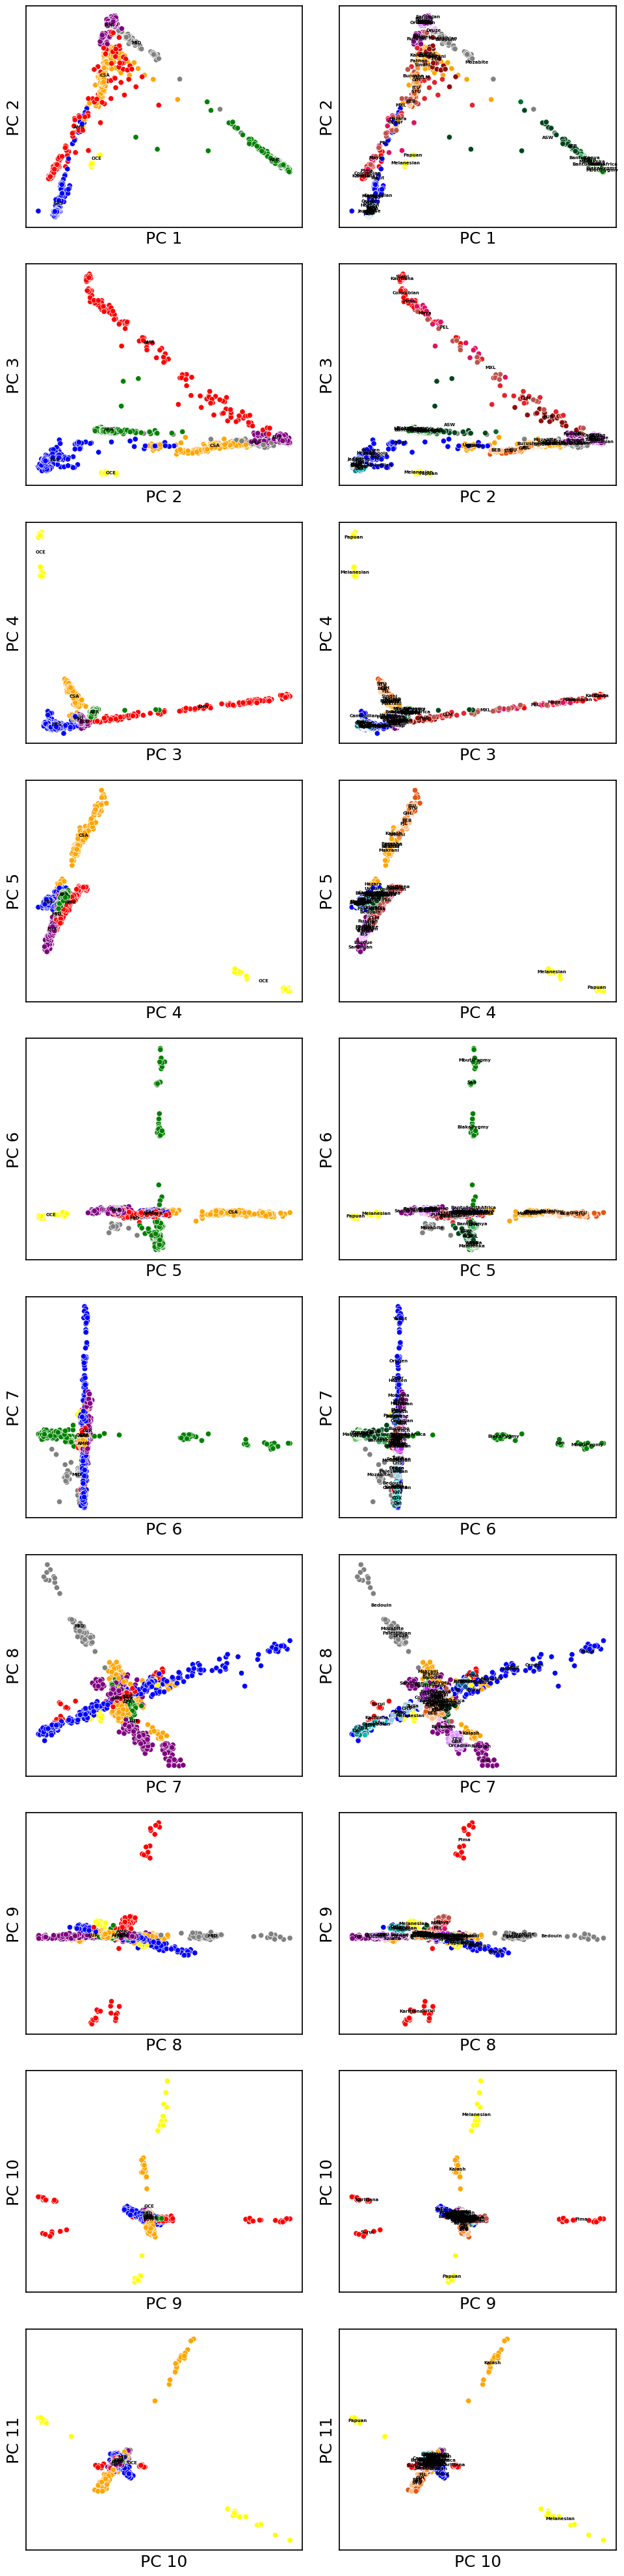

In [19]:
# Just look at subset
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,40))
for comp in range(10):
# initial 2D phate embedding
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Superpopulation'].values[idx_to_keep], 
                             None,
                             pop_palette_hgdp_coarse,
                             label_order_hgdp_coarse,
                             True,
                             ax[comp, 0])
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Population'].values[idx_to_keep], 
                             None,
                             pop_palette_hgdp_fine,
                             label_order_hgdp_fine,
                             True,
                             ax[comp, 1])
    #ax[comp, 0].get_legend().remove()
    #ax[comp, 1].get_legend().remove()
    ax[comp, 0].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 0].set_ylabel('PC {}'.format(comp+2))
    ax[comp, 1].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 1].set_ylabel('PC {}'.format(comp+2))
plt.tight_layout()
fig.savefig('figures/PCA_1000G+HGDP_uniformsubset')

In [20]:
# Now transform the rest
pca_input = pca_obj.transform(inputs)

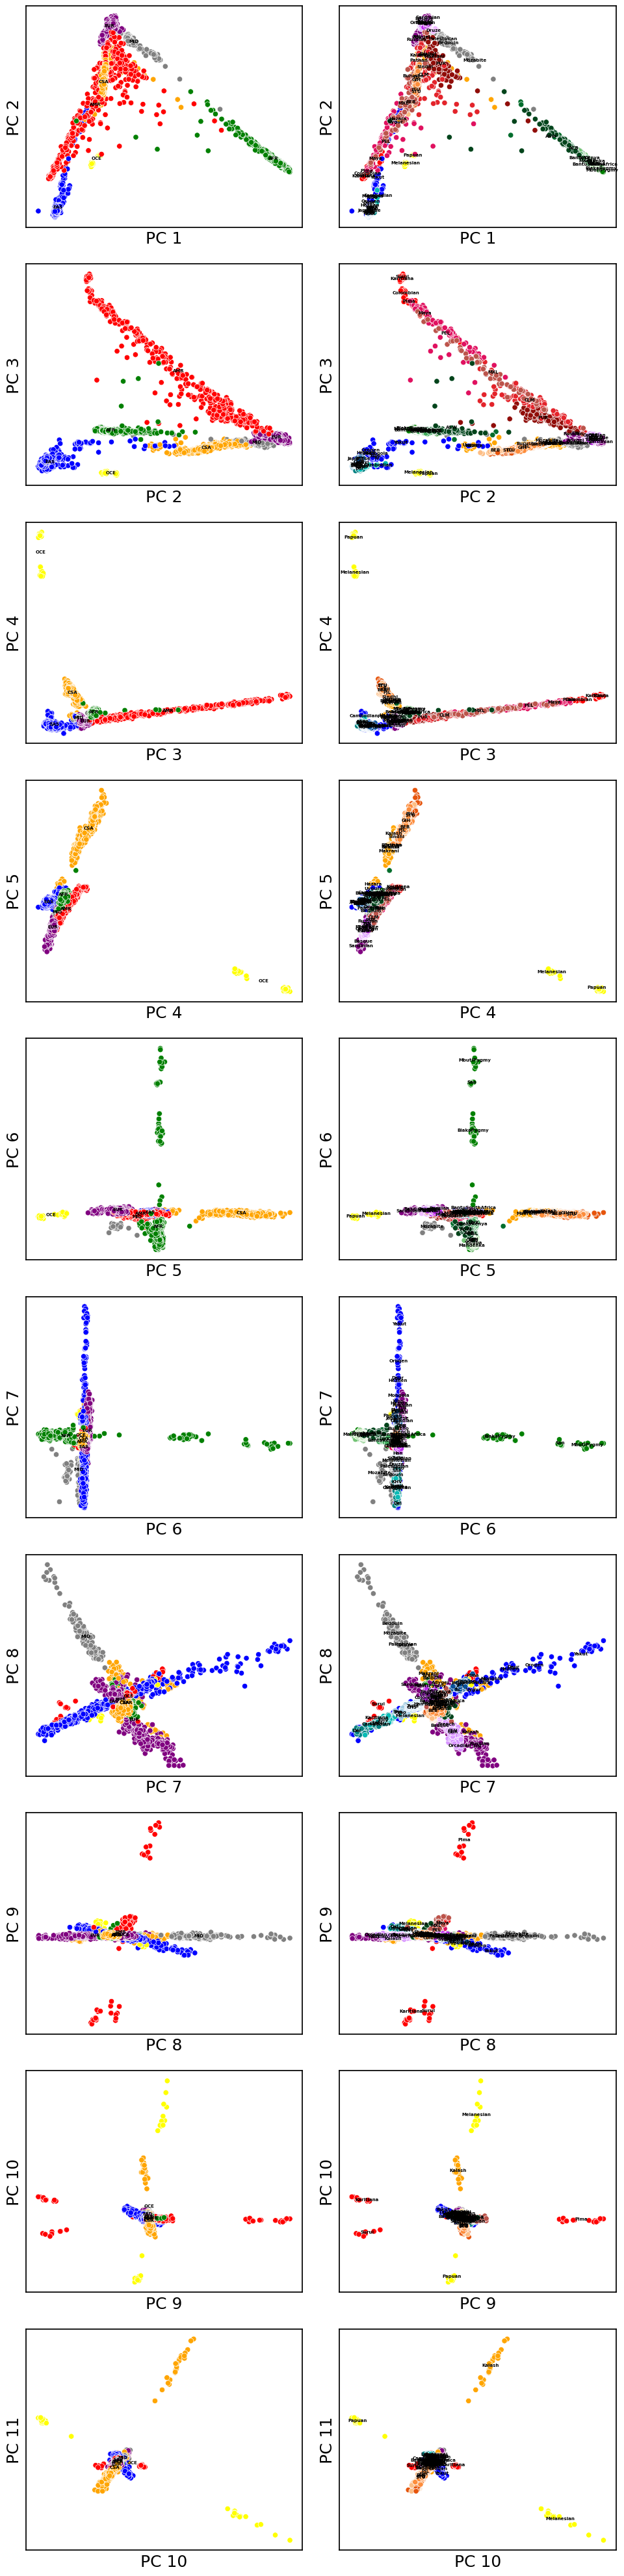

In [21]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,40))
for comp in range(10):
# initial 2D phate embedding
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Superpopulation'].values, 
                             None,
                             pop_palette_hgdp_coarse,
                             label_order_hgdp_coarse,
                             True,
                             ax[comp, 0])
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels['Population'].values, 
                             None,
                             pop_palette_hgdp_fine,
                             label_order_hgdp_fine,
                             True,
                             ax[comp, 1])
    #ax[comp, 0].get_legend().remove()
    #ax[comp, 1].get_legend().remove()
    ax[comp, 0].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 0].set_ylabel('PC {}'.format(comp+2))
    ax[comp, 1].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 1].set_ylabel('PC {}'.format(comp+2))
plt.tight_layout()
fig.savefig('figures/PCA_1000G+HGDP_uniformsubset+transformrest')